In [1]:
import paddle

In [2]:
def create_toy_data(func, interval, sample_num, noise = 0.0, add_outlier = False, outlier_ratio = 0.001):
    """
    根据给定的函数，生成样本
    输入:
    - func: 函数
    - interval: x的取值范围
    - sample_num: 样本数目
    - noise: 噪声均方差
    - add_outlier: 是否生成异常值
    - outlier_redio: 异常值占比
    输出:
    - X: 特征数据, shape=[n_samples,1]
    - y: 标签数据, shape=[n_samples,1]
    """

    # 均匀采样
    # 使用paddle.rand生成sample_num个随机数
    X = paddle.rand(shape = [sample_num])*(interval[1]-interval[0])+interval[0]
    y = func(X)
    # 生成高斯分布的标签噪声
    # 使用paddle.normal生成0均值，noise标准差的数据
    epsilon = paddle.normal(0, noise, paddle.to_tensor(y.shape[0]))
    y = y + epsilon
    if add_outlier:  # 生成额外的异常点
        outlier_num = int(len(y)*outlier_ratio)
        if outlier_num != 0:
            # 使用paddle.randint生成服从均匀分布的、范围在[0,len(y)]的随机张量
            outlier_idx = paddle.randint(len(y), shape = [outlier_num])
            y[outlier_idx] = y[outlier_idx]*5
    return X, y


In [3]:
# 真实函数的参数缺省值为 w=1.2, b=0.5
def linear_func(x, w=1.2, b=0.5):
    y = w*x + b
    return y

W0607 10:55:44.058990   287 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.8
W0607 10:55:44.061149   287 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.


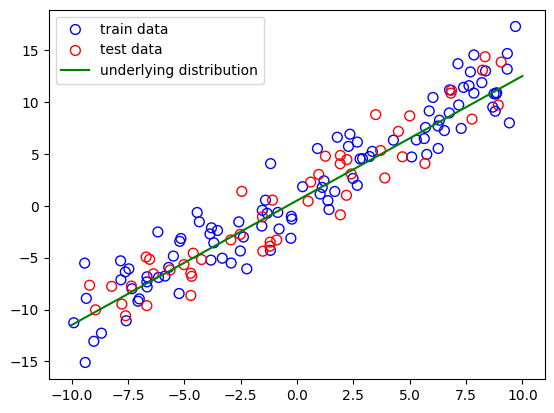

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt  # matplotlib是Python的绘图库

# 生成训练数据
X_train, y_train = create_toy_data(func=linear_func, interval=(-10, 10), sample_num=100, noise=2, add_outlier=False)
# 生成测试数据
X_test, y_test = create_toy_data(func=linear_func, interval=(-10, 10), sample_num=50, noise=2, add_outlier=False)
# 生成用来绘制函数曲线的数据
# 返回一个张量，值为区间在start和stop上均匀间隔的num个值，输出张量的长度为num
X_underlying = paddle.linspace(-10,10,100)
y_underlying = linear_func(X_underlying)
X_underlying_np = X_underlying.numpy()
y_underlying_np = y_underlying.numpy()
# 可视化ToyLinear150数据集
plt.scatter(X_train, y_train, facecolor="none", edgecolors="b", s=50, label="train data")
plt.scatter(X_test, y_test, facecolor="none", edgecolors="r", s=50, label="test data")
plt.plot(X_underlying_np, y_underlying_np, c="g", label="underlying distribution")
plt.legend()
plt.show()

In [5]:
from nndl.op import Op

paddle.seed(10)  # 设置随机种子
# 线性算子
class Linear(Op):
    def __init__(self, input_size):
        """
        输入：
        - input_size：模型要处理的数据特征向量长度
        """
        self.input_size = input_size
        # 模型参数
        self.params = {}
        self.params['w'] = paddle.randn(shape=[self.input_size, 1], dtype='float32')
        self.params['b'] = paddle.zeros(shape=[1], dtype='float32')

    def __call__(self, X):
        return self.forward(X)

    # 前向函数
    def forward(self, X):
        """
        输入：
        - X：tensor, shape=[N, D]
        输出：
        - y_pred: shape=[N]
        """
        N,D = X.shape
        if self.input_size == 0:
            return paddle.full(shape=[N,1], fill_value=self.params['b'])
        
        assert D == self.input_size  # 输入数据维度合法性验证
        # 使用paddle.matmul计算两个张量的乘积
        y_pred = paddle.matmul(X, self.params['w'])+self.params['b']
        return y_pred

input_size = 3
N = 2
X = paddle.randn(shape=[N, input_size],dtype='float32')
model = Linear(input_size)
y_pred = model(X)
print("y_pred: ",y_pred)

y_pred:  Tensor(shape=[2, 1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[ 2.90376997],
        [-0.72704077]])


In [6]:
def mean_squared_error(y_true, y_pred):
    assert y_true.shape[0] == y_pred.shape[0]
    error = paddle.mean(paddle.square(y_true-y_pred))
    return error

y_true = paddle.to_tensor([[-0.2],[4.9]], dtype='float32')
y_pred = paddle.to_tensor([[1.3],[2.5]], dtype='float32')
error = mean_squared_error(y_true=y_true, y_pred=y_pred).item()
print("error: ",error)

error:  4.005000114440918


In [7]:
def optimizer_lsm(model, X, y, reg_lambda=0):
    N, D = X.shape
    x_bar_tran = paddle.mean(X, axis=0).T
    y_bar = paddle.mean(y)
    x_sub = paddle.subtract(X, x_bar_tran)
    if paddle.all(x_sub==0):
        model.params['b'] = y_bar
        model.params['w'] = paddle.zeros(shape=[D])
        return model
    tmp = paddle.inverse(paddle.matmul(x_sub.T, x_sub)+reg_lambda*paddle.eye(num_rows=(D)))
    w = paddle.matmul(paddle.matmul(tmp,x_sub.T), (y-y_bar))
    b = y_bar - paddle.matmul(x_bar_tran, w)
    model.params['b'] = b
    model.params['w'] = paddle.squeeze(w, axis=-1)
    return model

In [8]:
input_size = 1
model = Linear(input_size)
model = optimizer_lsm(model,X_train.reshape([-1,1]),y_train.reshape([-1,1]))
print("w_pred: ",model.params['w'].item(),"b_pred: ",model.params['b'].item())

y_train_pred = model(X_train.reshape([-1,1])).squeeze()
train_error = mean_squared_error(y_true=y_train,y_pred=y_train_pred).item()
print("train error: ",train_error)

w_pred:  1.2230405807495117 b_pred:  0.8996497392654419
train error:  4.834457874298096


In [9]:
y_test_pred = model(X_test.reshape([-1,1])).squeeze()
test_error = mean_squared_error(y_true=y_test, y_pred=y_test_pred).item()
print("test error: ",test_error)

test error:  4.382524013519287


In [10]:
import math

def sin(x):
    y = paddle.sin(2*math.pi*x)
    return y

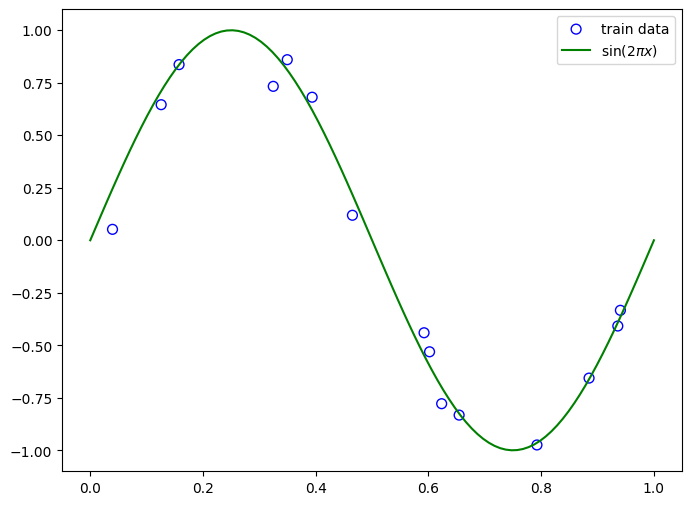

In [13]:
# 生成训练数据
X_train, y_train = create_toy_data(func=sin, interval=(0, 1), sample_num=15, noise=0.1, add_outlier=False)
# 生成测试数据
X_test, y_test = create_toy_data(func=sin, interval=(0, 1), sample_num=10, noise=0.1, add_outlier=False)
# 生成用来绘制函数曲线的数据
# 返回一个张量，值为区间在start和stop上均匀间隔的num个值，输出张量的长度为num
X_underlying = paddle.linspace(0,1,100)
y_underlying = sin(X_underlying)
X_underlying_np = X_underlying.numpy()
y_underlying_np = y_underlying.numpy()
# 可视化ToyLinear150数据集
plt.rcParams['figure.figsize'] = (8.0, 6.0)
plt.scatter(X_train, y_train, facecolor="none", edgecolors="b", s=50, label="train data")
plt.plot(X_underlying_np, y_underlying_np, c="g", label=r"$\sin(2\pi x)$")
plt.legend()
plt.show()

In [14]:
def polynomial_basis_function(x, degree=2):
    if degree==0:
        return paddle.ones(shape=x.shape,dtype="float32")

    x_tmp = x
    x_result = x_tmp
    for i in range(2, degree+1):
        x_tmp = paddle.multiply(x_tmp, x)
        x_result = paddle.concat((x_result, x_tmp), axis=-1)
    return x_result

data = [[2], [3], [4]]
X = paddle.to_tensor(data=data, dtype="float32")
degree = 3
transformed_X = polynomial_basis_function(X, degree=degree)
print("变换前：",X)
print("变换后：",transformed_X)    

变换前： Tensor(shape=[3, 1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[2.],
        [3.],
        [4.]])
变换后： Tensor(shape=[3, 3], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[2. , 4. , 8. ],
        [3. , 9. , 27.],
        [4. , 16., 64.]])


{'w': Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [0.]), 'b': Tensor(shape=[], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       -0.06846698)}


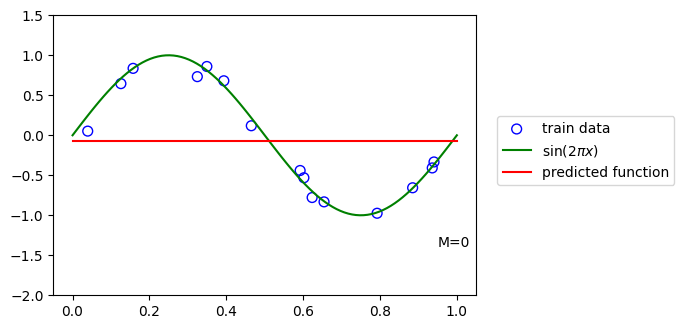

{'w': Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [-1.69978857]), 'b': Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [0.82464904])}


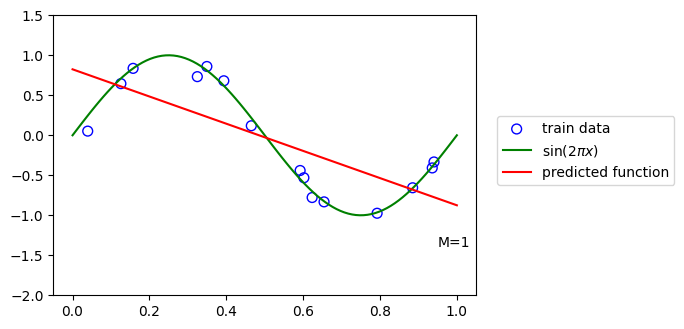

{'w': Tensor(shape=[3], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [ 13.93455315, -38.83592606,  25.73077774]), 'b': Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [-0.47985470])}


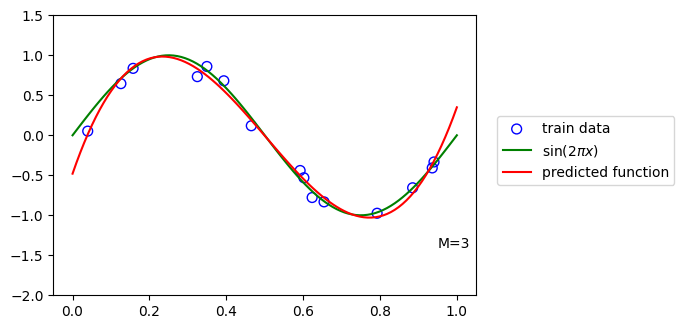

{'w': Tensor(shape=[8], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [ 11.02655602, -23.95346069, -0.02636719 ,  12.41925049, -2.27113342 ,
         4.50691223 ,  14.42193604, -16.29879761]), 'b': Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [-0.28936219])}


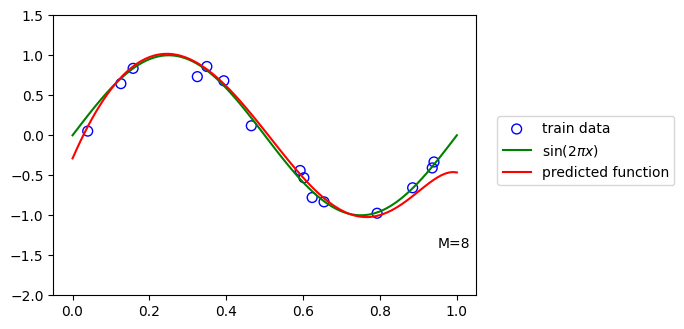

In [17]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)

for i, degree in enumerate([0, 1, 3, 8]):
    model = Linear(degree)
    X_train_transformed = polynomial_basis_function(X_train.reshape([-1,1]), degree)
    X_underlying_transformed = polynomial_basis_function(X_underlying.reshape([-1,1]), degree)

    model = optimizer_lsm(model, X_train_transformed, y_train.reshape([-1,1]))
    y_underlying_pred = model(X_underlying_transformed).squeeze()
    print(model.params)

    plt.subplot(2, 2, i+1)
    plt.scatter(X_train, y_train, facecolor="none", edgecolors="b", s=50, label="train data")
    X_underlying_np = X_underlying.numpy()
    y_underlying_np = y_underlying.numpy()
    y_underlying_pred_np = y_underlying_pred.numpy()
    plt.plot(X_underlying_np, y_underlying_np, c="g", label=r"$\sin(2\pi x)$")
    plt.plot(X_underlying_np, y_underlying_pred_np, c="r", label="predicted function")
    plt.ylim(-2, 1.5)
    plt.annotate(f"M={degree}", xy=(0.95, -1.4)) 
    plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)
    plt.show()

train errors:  [0.4157197177410126, 0.18429110944271088, 0.18414172530174255, 0.005468401126563549, 0.005464830435812473, 0.004365795291960239, 0.9636358618736267, 1.3919953107833862, 0.011340864934027195]
test errors:  [0.6551933884620667, 0.20042307674884796, 0.1979639083147049, 0.013393044471740723, 0.01364227756857872, 0.01520182192325592, 0.8851003646850586, 1.0071189403533936, 0.01691887155175209]


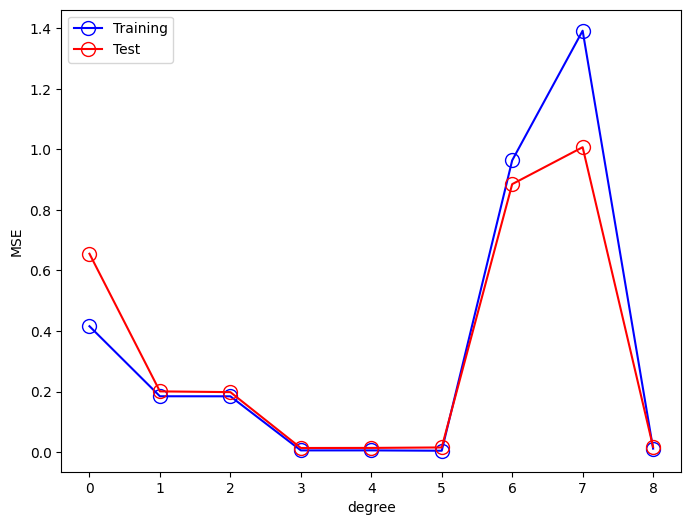

In [19]:
training_errors = []
test_errors = []
distribution_errors = []

for i in range(9):
    model = Linear(i)
    X_train_transformed = polynomial_basis_function(X_train.reshape([-1,1]), i)
    X_test_transformed = polynomial_basis_function(X_test.reshape([-1,1]), i)
    optimizer_lsm(model, X_train_transformed, y_train.reshape([-1,1]))
    y_train_pred = model(X_train_transformed).squeeze()
    y_test_pred = model(X_test_transformed).squeeze()
    train_mse = mean_squared_error(y_true=y_train, y_pred=y_train_pred).item()
    training_errors.append(train_mse)
    test_mse = mean_squared_error(y_true=y_test, y_pred=y_test_pred).item()
    test_errors.append(test_mse)

print("train errors: ",training_errors)
print("test errors: ",test_errors)

plt.rcParams['figure.figsize'] = (8.0, 6.0)
plt.plot(training_errors, 'o-', mfc="none", mec="b", ms=10, c="b", label="Training")
plt.plot(test_errors, 'o-', mfc="none", mec="r", ms=10, c="r", label="Test")
plt.legend()
plt.xlabel("degree")
plt.ylabel("MSE")
plt.show()

In [21]:
degree = 7
reg_lambda = 0.0001
X_train_transformed = polynomial_basis_function(X_train.reshape([-1,1]), degree)
X_test_transformed = polynomial_basis_function(X_test.reshape([-1,1]), degree)
X_underlying_transformed = polynomial_basis_function(X_underlying.reshape([-1, 1]), degree)

model = Linear(degree)
optimizer_lsm(model, X_train_transformed, y_train.reshape([-1,1]))

y_test_pred = model(X_test_transformed).squeeze()
y_underlying_pred = model(X_underlying_transformed).squeeze()

model_reg = Linear(degree)
optimizer_lsm(model_reg, X_train_transformed, y_train.reshape([-1,1]), reg_lambda=reg_lambda)

y_test_pred_reg = model_reg(X_test_transformed).squeeze()
y_underlying_pred_reg = model_reg(X_underlying_transformed).squeeze()

mse = mean_squared_error(y_true=y_test, y_pred=y_test_pred).item()
print("mse: ",mse)
mse_reg = mean_squared_error(y_true=y_test, y_pred=y_test_pred_reg).item()
print("mse with reg: ",mse_reg)

mse:  1.0071189403533936
mse with reg:  0.018159590661525726


In [22]:
class Runner(object):
    def __init__(self, model, optimizer, loss_fn, metric):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.metric = metric
    
    def train(self, train_dataset, dev_dataset=None, **kwargs):
        pass

    def evaluate(self, data_set, **kwargs):
        pass

    def predict(self, x, **kwargs):
        pass

    def save_model(self, save_path):
        pass

    def load_model(self, model_path):
        pass